### Bayesian Networks 2
**Pomegranate 1.1.0**


This text and the picture comes from **Nicolas Bertagnolli** https://www.nbertagnolli.com/jekyll/update/2016/05/23/Bayes_Nets.html

Imagine that we are doctors and we want to **predict** whether or not a patient will have
a **heart attack**. We have a few pieces of information that we can collect like the patients
**cholesterol**, whether or not they **smoke**, their **blood pressure**, and whether or not they **exercise**.

We’re doctors and we know some things about this disease. For example, we know that blood
pressure is directly related to heart attacks and that both exercise and smoking can affect
blood pressure. Thus we can build a model like the one in Figure where we use our domain
knowledge to describe the interactions between our features.

This picture shows us a number of things about our problem and our assumptions. First off we
see the prior probabilities of the individual being a smoker, and whether or not they exercise. 
We can see that being a smoker affects the individuals cholesterol level influencing whether
it is either high (T) or low (F). We also see that the blood pressure is directly influenced
by exercise and smoking habits, and that blood pressure influences whether or not our patient
is going to have a heart attack.

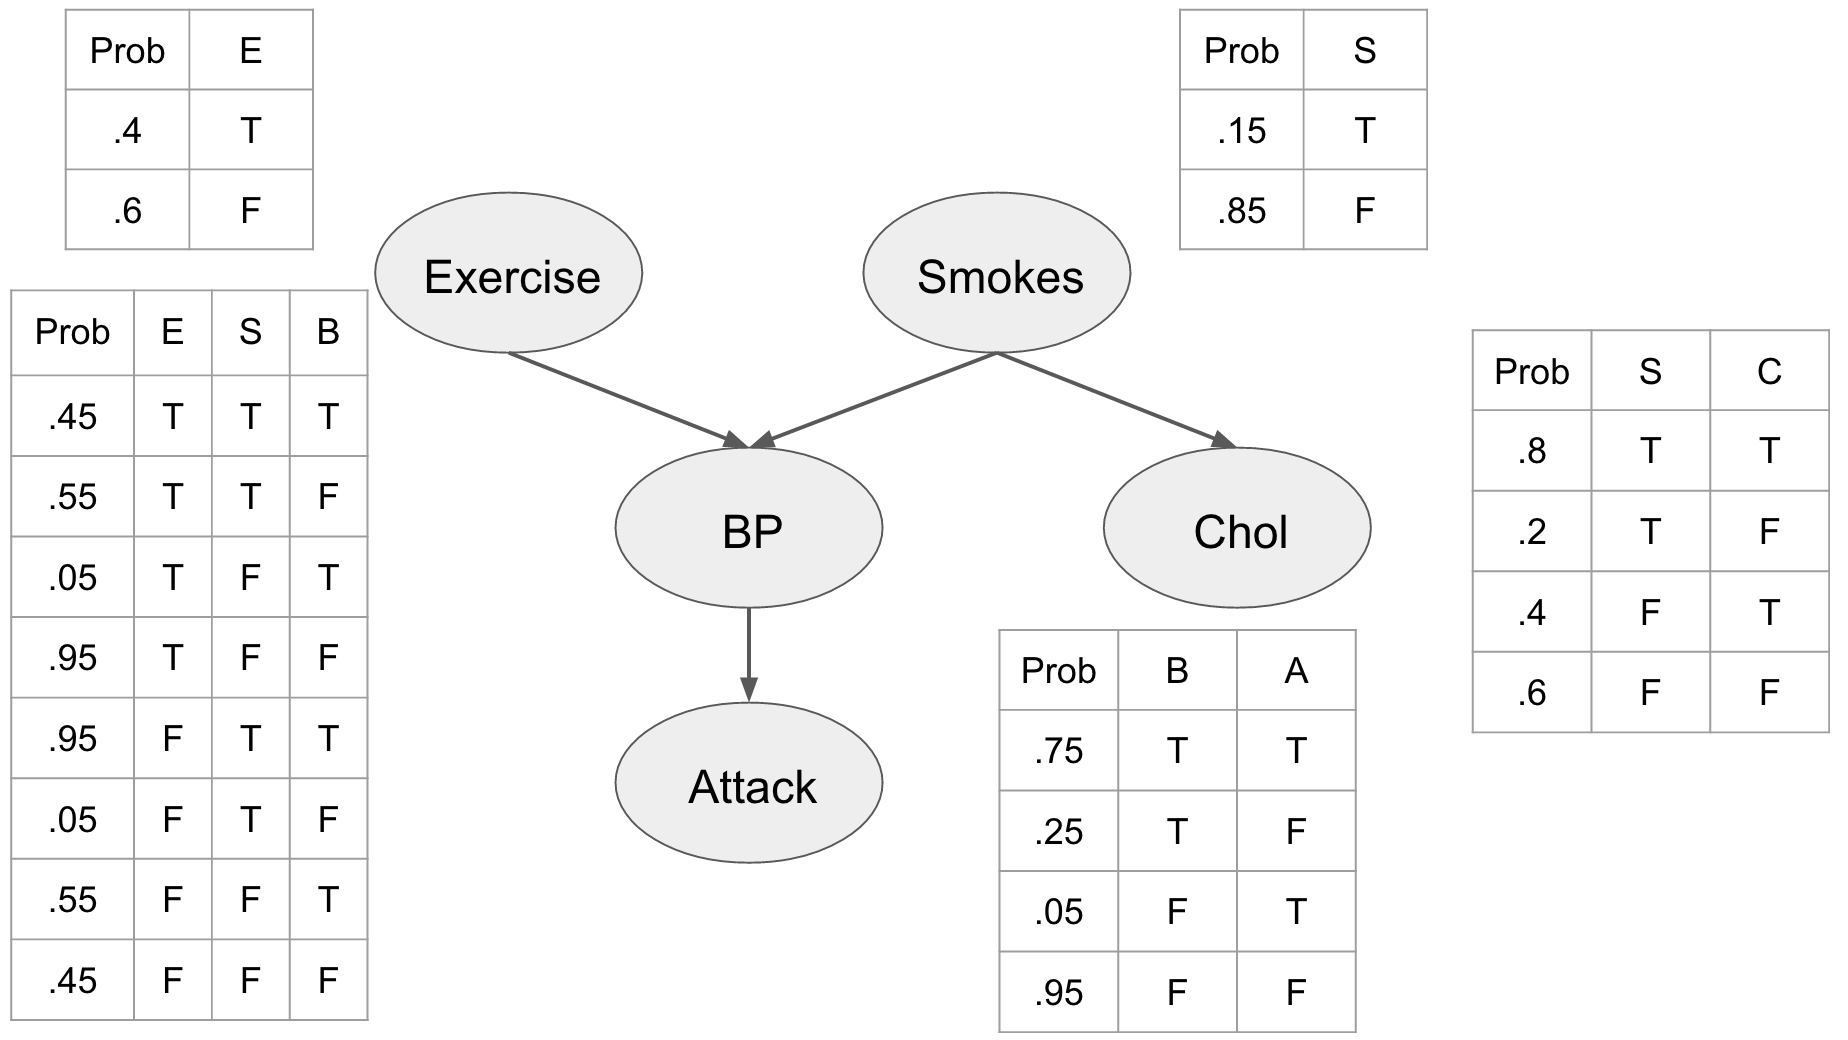

In [1]:
# INIT
import torch
import numpy
from pomegranate.distributions import Categorical
from pomegranate.distributions import ConditionalCategorical
from pomegranate.bayesian_network import BayesianNetwork
from pomegranate.bayes_classifier import BayesClassifier
from pomegranate.distributions import *



In [2]:
# MODEL DEFINITION
# Let's use the notation F=False=0 and T=True=1   

# A priori probabilities for nodes E and S:
#                 [P(0), P(1)]
E = Categorical([[0.60, 0.40]])                   
S = Categorical([[0.85, 0.15]])                  

# Conditional probabilities for nodes B: P(B|ES)
#  [[P(0|00), P(1|00)],  [P(0|01), P(1|01)]],
#  [[P(0|10), P(1|10)],  [P(0|11), P(1|11)]]
B_probs = numpy.array([[
     [[0.45, 0.55], [0.05, 0.95]], 
     [[0.95, 0.05], [0.55, 0.45 ]],
     ]])  
B = ConditionalCategorical(B_probs)

C = ConditionalCategorical([[[0.60, 0.40], [0.20, 0.80]]])
#                [P(C=0|S=0), P(C=1|S=0)], [P(C=0|S=1), P(C=1|S=1)]

A = ConditionalCategorical([[[0.95, 0.05], [0.25, 0.75]]])
#                [P(A=0|B=0), P(A=1|B=0)], [P(A=0|B=1), P(A=1|B=1)]
                               
model = BayesianNetwork([E, S, B, C, A], [(E, B), (S, B), (S, C), (B, A)]) 
#                nodes:  0  1  2  3  4                   edges                               


In [3]:
print('Probability distribution tensors E S B C A')
print()
print(model.distributions[0].probs[0])  
print(model.distributions[1].probs[0])  
print(model.distributions[2].probs[0])  
print(model.distributions[3].probs[0])  
print(model.distributions[4].probs[0])  
print()

# How to get the probability values out from tensor B
print(model.distributions[2].probs[0][1][0].numpy() )
print(model.distributions[2].probs[0][1][0][1].numpy() )

Probability distribution tensors E S B C A

tensor([0.6000, 0.4000])
tensor([0.8500, 0.1500])
Parameter containing:
tensor([[[0.4500, 0.5500],
         [0.0500, 0.9500]],

        [[0.9500, 0.0500],
         [0.5500, 0.4500]]], dtype=torch.float64)
Parameter containing:
tensor([[0.6000, 0.4000],
        [0.2000, 0.8000]])
Parameter containing:
tensor([[0.9500, 0.0500],
        [0.2500, 0.7500]])

[0.95 0.05]
0.05


In [12]:
#CAUSAL REASONING

# What is known?
# Mark known nodes with their values and unknown ones with -1.
# Let’s assume that all we know about the patient if he is a smoker (S=1) or not (S=0).
# So we have two cases:
#                   E  S   B   C   A
X = torch.tensor([[-1, 0, -1, -1, -1],
                  [-1, 1, -1, -1, -1]])                 

# Create a mask tensor from X
X_masked = torch.masked.MaskedTensor(X, mask = X >= 0)
print()
model.predict_proba(X_masked)

[tensor([[0.6000, 0.4000],
         [0.6000, 0.4000]]),
 tensor([[1., 0.],
         [0., 1.]]),
 tensor([[0.6500, 0.3500],
         [0.2500, 0.7500]]),
 tensor([[0.6000, 0.4000],
         [0.2000, 0.8000]]),
 tensor([[0.7050, 0.2950],
         [0.4250, 0.5750]])]

<img src="Pomegr_Bayes5.png" alt="drawing" width="500"/>

In [5]:
 # The most probable states for the network can now be calculated for non smoker and smoker
model.predict(X_masked) 

tensor([[0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1]])

In [15]:
# Probabilities for each node to be in state 0 or 1.
print('            P(0)   P(1)       E S B C A')
pred = model.predict_proba(X_masked)
pred

            P(0)   P(1)       E S B C A


[tensor([[0.6000, 0.4000],
         [0.6000, 0.4000]]),
 tensor([[1., 0.],
         [0., 1.]]),
 tensor([[0.6500, 0.3500],
         [0.2500, 0.7500]]),
 tensor([[0.6000, 0.4000],
         [0.2000, 0.8000]]),
 tensor([[0.7050, 0.2950],
         [0.4250, 0.5750]])]

Above, the upper row in each tensor is for a 'non-smoker' (S=0)  and the lower row for a smoker (S=1). <br> 
The numbers in brackets are &nbsp; [P(0), P(1)]  &nbsp; where &nbsp; P(0)+ P(1) = 1
1. Tensor. The a priori probabilities of node E as such.
2. Tensor. The probabilities of node S are known: for a smoker [P(S=0) = 0, P(S=1) = 1]
3. Tensor. Node B: For a smoker P(B=1|S=1) = 0.75
4. Tensor. The probabilities of node C come directly from the probability distribution of C.
5. Tensor. Node A: The probability of a non-smoker having an attack is only 0.295 in comparison
   to 0.575 of a smoker.

In [7]:
# Taking a values out of the Torch tensor
print('For a smoker, [P(A=0|S=1, P(A=1|S=1]  is', pred[4][1].numpy())
print('For a smoker, the probability of an attack is', pred[4][1][1].numpy())
# OBS! print(torch.tensor([0.0243]).item())  # When there is only one item in the tensor.

For a smoker, [P(A=0|S=1, P(A=1|S=1]  is [0.425 0.575]
For a smoker, the probability of an attack is 0.575


In [8]:
# With both risk factors E=0 and S=1
#                  E  S   B   C   A
X = torch.tensor([[0, 1, -1, -1, -1]])
X_masked = torch.masked.MaskedTensor(X, mask = X >= 0)
pred = model.predict_proba(X_masked)
print('With both risk factors the probability of an attack is', pred[4][0][1].numpy())

With both risk factors the probability of an attack is 0.715


In [9]:
# EVIDENTIAL REASONING
# We will use the evidence of a heart attack to better understand the patients initial state.

# The person had an attack and died. What is the probability that he had high blood pressure?
#                   E   S   B   C  A
X = torch.tensor([[-1, -1, -1, -1, 1]])
X_masked = torch.masked.MaskedTensor(X, mask = X >= 0)
pred = model.predict_proba(X_masked)
print('The probability of high blood pressure is', pred[2][0][1].numpy())

The probability of high blood pressure is 0.9124629


In [10]:
# INTERCAUSAL REASONING
# Information flows between two otherwise independent pieces of evidence.

# It is known that the patient has high blood pressure (B=1).  
# Let's compare the probability of exercise P(E=1) in situations where is
# a) not known about smoking (S=-1)
# b) known to smoke (S=1)
# The state vectors of the both network situations are below.
#                   E   S  B   C   A
X = torch.tensor([[-1, -1, 1, -1, -1],
                  [-1,  1, 1, -1, -1]
                 ])
X_masked = torch.masked.MaskedTensor(X, mask = X >= 0)
#model.predict_proba(X_masked)
P0 = model.predict_proba(X_masked)[0][0][1].item()          # a)
print('P(E=1|B=1) =', round(P0, 2))                       
P1 = model.predict_proba(X_masked)[0][1][1].item()          # b)
print('P(E=1|B=1,S=1) =',round(P1, 3))                      


P(E=1|B=1) = 0.11
P(E=1|B=1,S=1) = 0.24


It is noticed  from above that information S=1 (smoker) has flowed to node E, where the probability of exercise has more than doubled even though the nodes E and S are not causally connected in the first place.

<img src="Pomegr_Bayes5.png" alt="drawing" width="500"/>

Heikki Miettinen 2024